In [217]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import numpy as np
import PIL
import time

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.data import Dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [216]:
(train_images, _), (test_images, _) = mnist.load_data()

In [215]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [214]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1))/255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

In [212]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [211]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [210]:
train_size = 60000
batch_size = 32
test_size = 10000

In [209]:
train_dataset = (Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

In [219]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE,self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([InputLayer(input_shape=(28, 28, 1)), 
                                   Conv2D(filters=32, kernel_size=3, 
                                          strides=(2,2), activation='relu'), 
                                   Conv2D(filters=64, kernel_size=3, 
                                         strides=(2,2), activation='relu'),
                                   Flatten(),
                                   Dense(latent_dim + latent_dim)])
        
        self.decoder = Sequential([InputLayer(input_shape=(latent_dim, )),
                                   Dense(units=7*7*32, activation='relu'),
                                   Reshape(target_shape=(7,7,32)), 
                                   Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                                   Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                   Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),])
    def sample(self, eps=None):
        if eps is None:
          eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
        
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
       
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
   
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
          
        if apply_sigmoid:
           probs=tf.sigmoid(logits)
           return probs
          
        return logits
          

In [220]:
optimizer = Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 *((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_X = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_X)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [221]:
epochs = 10

latent_dim = 2 
num_examples_to_generate = 16


In [222]:
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [223]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,0], cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    

In [224]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
    



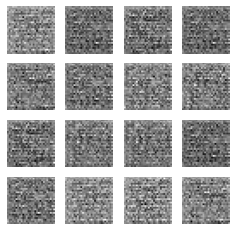

In [225]:
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: 1.3520911124942359e-05, Time: 7.921788454055786


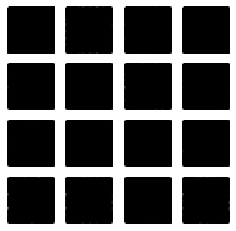

In [237]:
for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, Time: {}'.format(epoch, elbo, (end_time-start_time)))
    generate_and_save_images(model, epoch, test_sample)
    

In [233]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_eopch_{:04d}.png'.format(epoch_no))


In [238]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


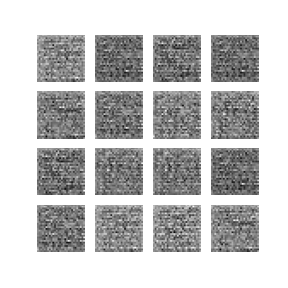

In [240]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [245]:
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0,1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95,n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
          z = np.array([[xi, yi]])
          x_decoded = model.sample(z)
          digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
          image[i * digit_size: (i+1) * digit_size, j *digit_size: (j+1) * digit_size] = digit.numpy()
          
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.show()

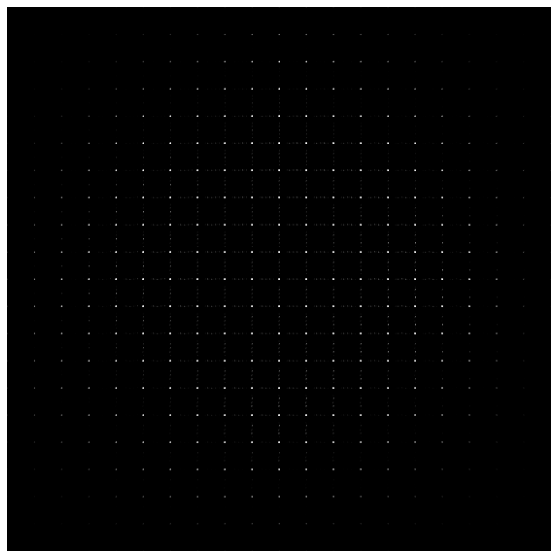

In [246]:
plot_latent_images(model, 20)